# **Detecção de um tabuleiro em uma imagem**

Para isto serão utilizados:

* Python 3.11.8
* Tensorflow 2.18.0
* Opencv-python 4.10.0

Os códigos serão escritos em python e a biblioteca tensorflow será usada para treinar o modelo de deep learning que deverá reconhecer um tabuleiro de xadrez em uma imagem e desenhar uma bounding box em volta dele. E a biblioteca opencv-python será usada para conectar o modelo de deep learning com a webcam, além de tirar as fotos.

-------------------------------------------------------------------------------------

### 1) Criando banco de dados

Começaremos criando o banco de dados que será usado para treinar o modelo de deep learning. Para isso iremos tirar 50 fotos de um tabuleiro de xadrez, com algulo e distância da webcam parecidos. Vale ressaltar que deverá haver variação no cenário e na quantidade de peças no tabuleiro com o intuito de garantir mais robustez ao modelo. Além disso, serão tiradas mais 25 fotos que não contém um tabuleiro. 

A seguir, o código usado para tirar as fotos:

In [1]:
import cv2
import os # essa biblioteca será usada para conectar com o sistema operacional
import tensorflow as tf

In [ ]:
IMAGENS_PATH = os.path.join("img", "imagens")

webcam = cv2.VideoCapture(0)
imgnum = 50
print('Coletando as imagens')

while True:
    _, imagem_frame = webcam.read()
    cv2.imshow('webcam', imagem_frame)

    if cv2.waitKey(1) == ord('q'): # Sai do loop quando aperta a tecla 'q'
        break

    elif cv2.waitKey(1) == ord('c'): # Tira uma foto quando aperta a tecla 'c'
        imgname = os.path.join(IMAGENS_PATH, "imagem"+f'{imgnum}'+'.jpg')
        cv2.imwrite(imgname, imagem_frame)
        print(f"Imagem {imgnum} capturada")
        imgnum +=1

    else: 
        continue

webcam.release()
cv2.destroyAllWindows()

As imagens foram todas tiradas e agora podemos ir para a segunda parte: rotular os tabuleiros nas imagens. Para isso será ultilizado um ferramenta muita usada para rotular objetos em imagens chamado labelme, que se encontra no seguinte repositório do GitHub: https://github.com/wkentaro/labelme 

In [3]:
PATH = os.path.join("img", "labelimg")

In [ ]:
# Usar o programa
!labelme

Agora que todas as imagens foram rotuladas temos a pasta 'imagens' que contém 75 imagens de um tabuleiro e 50 arquivos xml que contém as cordenadas dos rótulos de cada imagem (os rótulos são retangulos feitos nas bordas do tabuleiro). 

### 2) Formatando o banco de dados 

O intuito aqui é criar datasets com as imagens e as marcações para poder treinar o modelo de deep learning.

Primeiro vamos separar as imagens em três pastas: uma de treino, uma de teste e uma de validação. Em cada pasta também vamos separar as imagens em imagens e labels (os rótulos das imagens). A separação vai ser feita manualmente.

Dividiremos as imagens da seguinte forma: 55 imagens para treino, 10 imagens para teste e 10 imagens para validação.

Faremos também anotações mais simples com o nome da imagem, as coordenadas dos pontos e a classe: 0 para sem label e 1 para com label.

In [2]:
import json 
import numpy as np

In [14]:
# Formatando as imagens 

for pasta in ['treino', 'teste', 'val']:
    for imagem in os.listdir(os.path.join('img', pasta, 'imagens')):
        img = cv2.imread(os.path.join('img', pasta, 'imagens', imagem)) # todas as imagens de todas as pastas

        coords = [0,0,0,0,0,0,0,0]
        label_path = os.path.join('img', pasta, 'labels', f'{imagem.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as arquivo:
                label = json.load(arquivo)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords[4] = label['shapes'][0]['points'][2][0]
            coords[5] = label['shapes'][0]['points'][2][1]
            coords[6] = label['shapes'][0]['points'][3][0]
            coords[7] = label['shapes'][0]['points'][3][1]
            coords = list(np.divide(coords, [640,480,640,480,640,480,640,480]))

        try:

            anotacao = {}
            anotacao['imagem'] = imagem

            if os.path.exists(label_path): 
                anotacao['bbox'] = coords
                anotacao['classe'] = 1

            else:
                anotacao['bbox'] = coords
                anotacao['classe'] = 0

            with open(os.path.join('img', 'novas_labels', pasta, f'{imagem.split(".")[0]}.json'), 'w') as arquivo:
                json.dump(anotacao, arquivo)

        except Exception as e:
            print(e)

As novas labels foram criadas em uma pasta nomeada de novas_labels. A substituição das labels pelas novas labels será feita manualmente. 

Agora que temos 3 pastas (treino, teste e val) com suas respectivas imagens e labels vamos carregar as imagens para respectivos datasets do Tensorflow com a função carrega_imagem. Os valores dos pixels da matrix serão divididos por 255 para que fiquem entre 0 e 1, assim poderemos aplicar a função de ativação sigmoid que será explicada mais para frente. 

In [3]:
# Fazendo uma função para carregar as imagens 
def carrega_imagem(x):
    """Essa função recebe o path da imagem e carrega 
    a imagem como um array do numpy"""
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
imagens_treino = tf.data.Dataset.list_files('img\\treino\\imagens\\*.jpg', shuffle=False)
imagens_treino = imagens_treino.map(carrega_imagem)
imagens_treino = imagens_treino.map(lambda x: x/255)

imagens_teste = tf.data.Dataset.list_files('img\\teste\\imagens\\*.jpg', shuffle=False)
imagens_teste = imagens_teste.map(carrega_imagem)
imagens_teste = imagens_teste.map(lambda x: x/255)

imagens_val = tf.data.Dataset.list_files('img\\val\\imagens\\*.jpg', shuffle=False)
imagens_val = imagens_val.map(carrega_imagem)
imagens_val = imagens_val.map(lambda x: x/255)

imagens_treino.as_numpy_iterator().next()

Faremos o mesmo com as labels...

In [7]:
# Fazendo uma função para carregar as cordenadas da boundingbox de uma imagem em uma variável

def carrega_label(label) -> list:
    """Essa função recebe o path de uma label e 
    retorna uma lista com a classe e as cordenadas
    da bounding box dessa label"""

    with open(label.numpy(), 'r') as file:
        arquivo = json.load(file)
        
        return [arquivo['classe']], arquivo['bbox']

In [ ]:
# Carregando as labels
label_treino = tf.data.Dataset.list_files('img\\treino\\labels\\*.json', shuffle=False)
label_treino = label_treino.map(lambda x: tf.py_function(carrega_label, [x], [tf.uint8, tf.float16]))

label_teste = tf.data.Dataset.list_files('img\\teste\\labels\\*.json', shuffle=False)
label_teste = label_teste.map(lambda x: tf.py_function(carrega_label, [x], [tf.uint8, tf.float16]))

label_val = tf.data.Dataset.list_files('img\\val\\labels\\*.json', shuffle=False)
label_val = label_val.map(lambda x: tf.py_function(carrega_label, [x], [tf.uint8, tf.float16]))

label_teste.as_numpy_iterator().next() 

Agora podemos combinar as imagens com as labels em um dataset do tensorflow com a função zip

In [9]:
# O tamanho das amostras:

print(len(imagens_treino), len(imagens_teste), len(imagens_val), \
      len(label_treino), len(label_teste), len(label_val))

55 10 10 55 10 10


In [19]:
treino = tf.data.Dataset.zip((imagens_treino, label_treino))
treino = treino.batch(1)
treino = treino.prefetch(4)

teste = tf.data.Dataset.zip((imagens_teste, label_teste))
teste = teste.batch(1)
teste = teste.prefetch(4)

val = tf.data.Dataset.zip((imagens_val, label_val))
val = val.batch(1)
val = val.prefetch(4)

Agora temos três datasets em que cada item de cada dataset contem um array da imagem, uma classe (0 ou 1) e uma marcação caso a classe seja 1

In [32]:
treino.as_numpy_iterator().next()

(array([[[[0.50980395, 0.5764706 , 0.6392157 ],
          [0.5176471 , 0.5882353 , 0.6431373 ],
          [0.5176471 , 0.5882353 , 0.6431373 ],
          ...,
          [0.4509804 , 0.40392157, 0.31764707],
          [0.4509804 , 0.4       , 0.33333334],
          [0.45490196, 0.4117647 , 0.34117648]],
 
         [[0.5176471 , 0.58431375, 0.64705884],
          [0.5058824 , 0.5764706 , 0.6313726 ],
          [0.5019608 , 0.57254905, 0.61960787],
          ...,
          [0.4392157 , 0.38039216, 0.29803923],
          [0.44313726, 0.39215687, 0.3254902 ],
          [0.4509804 , 0.40784314, 0.3372549 ]],
 
         [[0.5294118 , 0.6       , 0.654902  ],
          [0.5019608 , 0.57254905, 0.627451  ],
          [0.49803922, 0.56078434, 0.6117647 ],
          ...,
          [0.43529412, 0.3764706 , 0.29411766],
          [0.44313726, 0.39215687, 0.3254902 ],
          [0.45490196, 0.40392157, 0.3372549 ]],
 
         ...,
 
         [[0.14901961, 0.22745098, 0.19215687],
          [0.14117

# 3) Construindo o modelo de deep learning

#### O deep learning:

O deep learning é uma parte do machine learning que usa várias camadas de processamento para que um modelo possa aprender determinado padrão. 

Funciona da seguinte forma: será provido um input para o modelo e nesse modelo deve haver várias camadas com neurônios para processar as informações recebidas. Esses neurônios são equações como esta: xw + b = y em que 'x' respresenta o as informações que serão rebidas, o 'w' representa o peso que essa informação terá o o 'b' é um bias que serve para adicionar mais sofisticação ao neurônio fazendo com que ele possa descobrir padrões que não dependem exclusivamente de x. Os neurônios podem ter mais de um 'x' e 'w' podendo haver neurônios incrivlemente complexos. 

Como uma segunda parte, os neurônios têm funções de ativação que servem para adicionar uma não linearidade as funções. Por exemplo, vamos supor que o resultado nunca pode ser negativo, para isso usaremos em cada neurônio uma função de ativação 'ReLU' (Unidade linear retificada) que retorna o valor recebido caso seja positivo e retorna 0 caso o valor recebido seja 0 ou negativo. Existem outras funções de ativação também. 

Como pode ser visto na imagem:

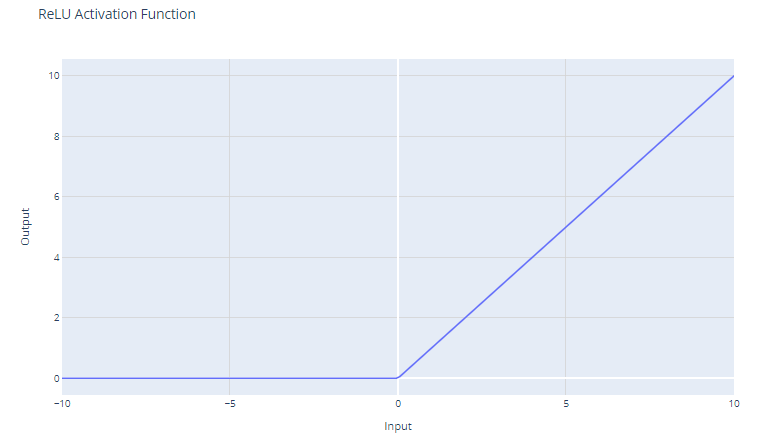

Também, usaremos a função de ativação sigmoid, que dado um valor ela retorna um número entre 0 e 1. Sendo que se dado o valor 0 ela retorna 0.5 e quanto maior o valor dado mais próximo de 1 será o output e quanto menor o valor mais perto de 0 vai ser o output. 

O gráfico da função é este a seguir:

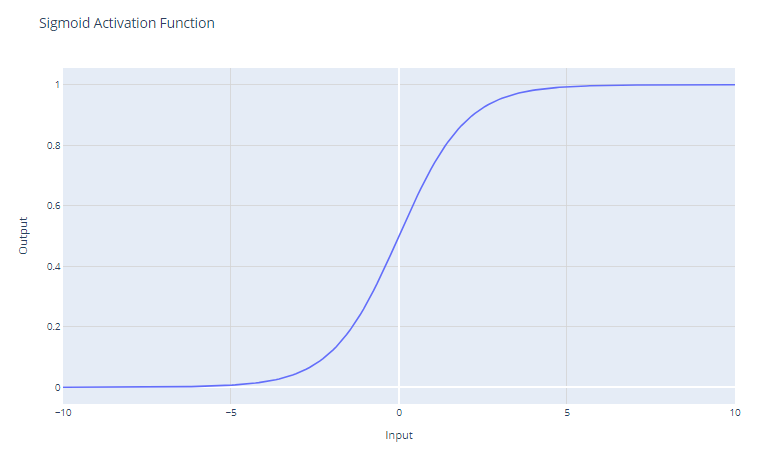

Portanto, o deep learning é um rede neural artificial com várias camadas e cada camada possue vários neurônios que processarão as informações recebidas para identificar padrões. 

Agora, quanto a parte de aprendizado, o que se faz para a rede aprender o padrão é ir mudando os valores de 'w' e o bias dos neurônios sempre que a rede neural não encontrar o padrão correto. Assim, a rede vai gradualmente aprendendo.

Na imagem a seguir é possível entender como são as entradas, o processamento e o resultado final. No caso desta imagem, os círculos vermelhos são as entradas são as informações que serão passadas para a rede, os círculos amarelos são os neurônios que possuem uma equação e uma funcção de ativação e os círculos azuis são as saídas que são os resultados esperados que servirão de base para ir atualizando os neurônios até que encontrem o padrão correto.

E a diferença entre o machine learning e o deep learning é que o deep learning possue várias camadas sendo capaz de mais processamento. A primeira rede é uma rede neural comum e a segunda é uma rede de aprendizado profundo. 

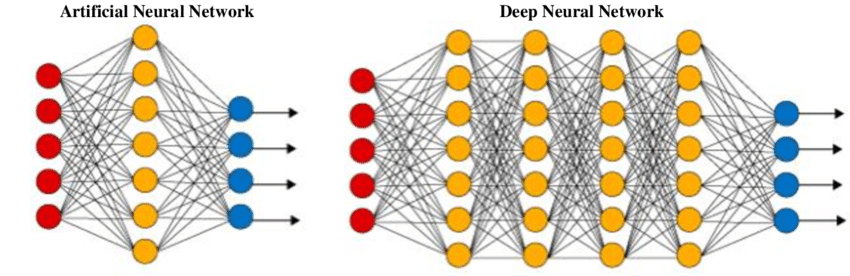

O tensorflow é um biblioteca open source criada pela Google em 2015 para construir modelos de machine learning, deep learning e IA. Nsse projeto usaremos o tensorflow para criarmos um modelo de classificação para determinar o que é o objeto (no caso um tabuleiro) e um de regressão para determinar a posição do tabuleiro na imagem. E por fim combinar os dois. Faremos isso usaremos a Functional API, que nos permite combinar os dois problemas que queremos resolver: o de classificação e o de regressão. 

In [12]:
# Começaremos importando as camadas (layers) para o nosso modelo 
# Também importaremos o vgg16 que é uma rede neural para detecção de imagens,
# nós usaremos o vgg16 como parte da nossa rede

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [13]:
vgg = VGG16(include_top=False)

In [14]:
# Função para construir a rede neural

def construir_modelo():
    """Essa função constroi o modelo de redes neurais"""
    input_layer = Input(shape=(480, 640, 3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Modelo de classificação  
    f1 = GlobalMaxPooling2D()(vgg)
    classificacao1 = Dense(2048, activation='relu')(f1) # função de ativação ReLU
    classificacao2 = Dense(1, activation='sigmoid')(classificacao1) # função de ativação sigmoid 
    
    # Modelo de regressão (encontrar as coordenadas do tabuleiro na imagem)
    f2 = GlobalMaxPooling2D()(vgg)
    regressao1 = Dense(2048, activation='relu')(f2)
    regressao2 = Dense(8, activation='sigmoid')(regressao1)
    
    detecta_tabuleiro = Model(inputs=input_layer, outputs=[classificacao2, regressao2])
    # a classe é a classificação de 1 ou 0 (tabuleiro ou não) e a regressão são as coordenadas
    return detecta_tabuleiro


In [15]:
# Criando a instância da rede neural usando a função que acabamos de criar
instancia = construir_modelo()
instancia.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 480, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 15, 20,    │ 14,714,688 │ input_layer_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │     16,392 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,834,377 (64.22 MB)

 Trainable params: 16,834,377 (64.22 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
X, y = treino.as_numpy_iterator().next()
print(X.shape)
classificacao, coordenadas = instancia.predict(X)

print(classificacao, coordenadas)

(1, 480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[0.5898036]] [[0.46721065 0.75462216 0.41972148 0.8987289  0.40818074 0.39199322
  0.61413443 0.2853213 ]]


#### Definindo loss e otimizadores

Agora que o nosso modelo já está fazendo predições, precisamos treinar ele para que essas predições sejam cada vez mais precisas.

Definindo a velociadade de aprendizado. A velocidade de aprendizado deve ir diminuindo para que não aconteça um overtraining, para isso cada epoch deve ter 75% do valor da anterior e deve levar em conta o tamanho do dataset. A seguir está uma fórmula para fazer isso.

In [ ]:
vp_decaimento = (1./0.75 - 1) / 55.0 # usaremos um decaimento de 0.006 na vp

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = vp_decaimento)

A loss é a distância entre o valor real e o valor previsto pelo modelo de deep learning. Vamos calcular ela a seguir para a regressão e para a classificação.

In [63]:
# Função para definir a loss

def loss_localizacao(y_real, y_prev):
    """Essa função recebe os 4 pontos originais e os 
    4 pontos previsto e calcular a loss dos pontos 
    baseado na altura e na largura da boundingbox"""
    delta_coord = tf.reduce_sum(tf.square(y_real[:,:2] - y_prev[:,:2]))
                  
    h_real = y_real[:,7] - y_real[:,1] 
    w1_real = y_real[:,2] - y_real[:,0]
    w2_real = y_real[:,6] - y_real[:,4]
    w_real = (w1_real + w2_real) / 2

    h_prev = y_prev[:,7] - y_prev[:,1] 
    w1_prev = y_prev[:,2] - y_prev[:,0]
    w2_prev = y_prev[:,6] - y_prev[:,4]
    w_prev = (w1_prev + w2_prev) / 2
    
    delta_tamanho = tf.reduce_sum(tf.square(w_real - w_prev) + tf.square(h_real-h_prev))
    
    return delta_coord + delta_tamanho

In [64]:
classificacao_loss = tf.keras.losses.BinaryCrossentropy()
regressao_loss = loss_localizacao

Treino do modelo